## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Mar 17 11:04:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download dataset from Roboflow Universe

In [5]:
from roboflow import download_dataset

dataset_abnormal = download_dataset('https://universe.roboflow.com/le-quy-don-high-school-for-gifted-students-gfeop/abnormal-activities-u130g/dataset/1', 'yolov8')
dataset_violence = download_dataset('https://universe.roboflow.com/securityviolence/violence-detection-p4qev/dataset/4', 'yolov8')
dataset_vandalism = download_dataset('https://universe.roboflow.com/tenyks-e8pra/vandalism-zfcdk/dataset/2', 'yolov8')
dataset_person = download_dataset('https://universe.roboflow.com/titulacin/person-detection-9a6mk/dataset/16', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Abnormal-Activities-1 in yolov8:: 100%|██████████| 19090/19090 [00:02<00:00, 7178.37it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to violence-detection-4 in yolov8:: 100%|██████████| 12264/12264 [00:02<00:00, 5224.93it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vandalism-2 in yolov8:: 100%|██████████| 4268/4268 [00:00<00:00, 5662.89it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Person-detection-16 in yolov8:: 100%|██████████| 10978/10978 [00:02<00:00, 4241.90it/s]


## Merging datasets into a unified dataset.

In [6]:
import os
import shutil

def merge_datasets(dataset_list, merged_dir):
    """
    Merge the train, valid, and test splits from multiple datasets into a unified directory.
    """
    for split in ['train', 'valid', 'test']:
        images_merged = os.path.join(merged_dir, split, 'images')
        labels_merged = os.path.join(merged_dir, split, 'labels')
        os.makedirs(images_merged, exist_ok=True)
        os.makedirs(labels_merged, exist_ok=True)
        for ds in dataset_list:
            src_images = os.path.join(ds.location, split, 'images')
            src_labels = os.path.join(ds.location, split, 'labels')
            if os.path.exists(src_images):
                for file in os.listdir(src_images):
                    shutil.copy(os.path.join(src_images, file), os.path.join(images_merged, file))
            if os.path.exists(src_labels):
                for file in os.listdir(src_labels):
                    shutil.copy(os.path.join(src_labels, file), os.path.join(labels_merged, file))

# Define the merged dataset directory
merged_dataset_dir = "merged_dataset"

# Merge all datasets into one
merge_datasets([dataset_abnormal, dataset_violence, dataset_vandalism, dataset_person], merged_dataset_dir)

In [7]:
!ls {merged_dataset_dir}

test  train  valid


## Remapping the other class names into a unified names

In [8]:
import os
import shutil

def remap_annotations(ann_dir, mapping, output_dir):
    """
    Remap YOLO annotation files in ann_dir using the provided mapping dictionary,
    and save the new annotation files to output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(ann_dir):
        if filename.endswith('.txt'):
            in_file = os.path.join(ann_dir, filename)
            out_file = os.path.join(output_dir, filename)
            with open(in_file, 'r') as fin, open(out_file, 'w') as fout:
                for line in fin:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    orig_id = int(parts[0])
                    if orig_id in mapping:
                        new_id = mapping[orig_id]
                        new_line = ' '.join([str(new_id)] + parts[1:]) + '\n'
                        fout.write(new_line)
                    else:
                        # If a class ID is not in mapping, either skip it or warn
                        print(f"Warning: no mapping for class id {orig_id} in file {filename}")

def copy_images(src_dir, dst_dir):
    """
    Copy all image files from src_dir to dst_dir (maintaining filenames).
    """
    os.makedirs(dst_dir, exist_ok=True)
    for filename in os.listdir(src_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            shutil.copy(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))

def process_dataset(dataset_name, mapping, merged_root):
    """
    Remap the annotations for train/valid/test splits of a single dataset,
    and copy both images and remapped labels to the merged_root folder.
    """
    # For each split: train, valid, test
    for split in ["train", "valid", "test"]:
        # Paths to the original dataset
        ann_dir = os.path.join(dataset_name, split, "labels")
        img_dir = os.path.join(dataset_name, split, "images")

        # Paths to the merged dataset
        merged_ann_dir = os.path.join(merged_root, split, "labels")
        merged_img_dir = os.path.join(merged_root, split, "images")

        # 1) Remap annotations
        remap_annotations(ann_dir, mapping, merged_ann_dir)
        # 2) Copy images
        copy_images(img_dir, merged_img_dir)


# ---------------------------
#  Define your mapping dictionaries
# ---------------------------

# Abnormal Activities dataset (16 classes)
mapping_abnormal = {
    0: 2,  # Aggressor -> violence
    1: 1,  # Discussion_WGI -> abnormal activity
    2: 1,  # Discussions_WOBoard -> abnormal activity
    3: 1,  # Discussions_ppl -> abnormal activity
    4: 1,  # Hand -> abnormal activity
    5: 1,  # Item_passed -> abnormal activity
    6: 2,  # Knife_Deploy -> violence
    7: 2,  # Knife_Weapon -> violence
    8: 1,  # NonViolence -> abnormal activity
    9: 0,  # Person -> person
    10: 2, # Stabbing -> violence
    11: 2, # Victim -> violence
    12: 2, # Violence -> violence
    13: 1, # Writing_Board -> abnormal activity
    14: 2, # gun -> violence
    15: 2  # hang -> violence
}

# Person detection dataset (1 class)
mapping_person = {
    0: 0  # Persona -> person
}

# Violence detection dataset (2 classes)
mapping_violence = {
    0: 1, # non_violence -> abnormal activity
    1: 2  # violence -> violence
}

# Vandalism dataset (??? classes)
# You must adjust this dictionary to match the original class IDs
# from your vandalism dataset. For example, if it has 1 class with ID 0:
mapping_vandalism = {
    0: 3  # original class -> vandalism
}


# ---------------------------
#  Process all four datasets
# ---------------------------

merged_dataset_dir = "merged_dataset"

# 1) Abnormal Activities dataset
process_dataset(
    dataset_name="Abnormal-Activities-1",  # <-- Adjust folder name if different
    mapping=mapping_abnormal,
    merged_root=merged_dataset_dir
)

# 2) Person detection dataset
process_dataset(
    dataset_name="Person-detection-16",     # <-- Adjust folder name if different
    mapping=mapping_person,
    merged_root=merged_dataset_dir
)

# 3) Violence detection dataset
process_dataset(
    dataset_name="violence-detection-4",   # <-- Adjust folder name if different
    mapping=mapping_violence,
    merged_root=merged_dataset_dir
)

# 4) Vandalism detection dataset
process_dataset(
    dataset_name="vandalism-2",  # <-- Adjust folder name if different
    mapping=mapping_vandalism,
    merged_root=merged_dataset_dir
)

print("All four datasets have been remapped and merged into:", merged_dataset_dir)


All four datasets have been remapped and merged into: merged_dataset


## Create a new `data.yaml` file for training.

In [9]:
import os

# Define the target directory for the merged dataset
merged_dir = "merged_dataset"
os.makedirs(merged_dir, exist_ok=True)

# Define the content of the data.yaml file
data_yaml_content = """train: ../merged_dataset/train/images
val: ../merged_dataset/valid/images
test: ../merged_dataset/test/images

nc: 4
names:
  - person
  - abnormal activity
  - violence
  - vandalism
"""

# Write the content to data.yaml
data_yaml_path = os.path.join(merged_dir, "data.yaml")
with open(data_yaml_path, "w") as file:
    file.write(data_yaml_content)

print(f"data.yaml has been created at: {data_yaml_path}")


data.yaml has been created at: merged_dataset/data.yaml


In [10]:
!cat {merged_dataset_dir}/data.yaml

train: ../merged_dataset/train/images
val: ../merged_dataset/valid/images
test: ../merged_dataset/test/images

nc: 4
names:
  - person
  - abnormal activity
  - violence
  - vandalism


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'/content/merged_dataset/data.yaml', epochs=150)

New https://pypi.org/project/ultralytics/8.3.91 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/merged_dataset/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

100%|██████████| 755k/755k [00:00<00:00, 23.8MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 27.5MB/s]


AMP: checks passed ✅


train: Scanning /content/merged_dataset/train/labels... 17448 images, 2028 backgrounds, 0 corrupt: 100%|██████████| 17448/17448 [00:07<00:00, 2469.47it/s]


train: New cache created: /content/merged_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/merged_dataset/valid/labels... 3881 images, 384 backgrounds, 0 corrupt: 100%|██████████| 3881/3881 [00:02<00:00, 1566.09it/s]


val: New cache created: /content/merged_dataset/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       6.7G      3.557      4.454      4.238         29        640: 100%|██████████| 1091/1091 [09:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:52<00:00,  2.32it/s]


                   all       3881       7092    0.00949     0.0128     0.0028   0.000863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      6.79G      3.057       4.07      3.634         45        640:  77%|███████▋  | 841/1091 [07:26<02:09,  1.93it/s]

## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   P_curve.png	     train_batch2.jpg
confusion_matrix_normalized.png			   PR_curve.png      train_batch540.jpg
confusion_matrix.png				   R_curve.png	     train_batch541.jpg
events.out.tfevents.1742201661.4f9b61ce9841.839.0  results.csv	     train_batch542.jpg
F1_curve.png					   results.png	     val_batch0_labels.jpg
labels_correlogram.jpg				   train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					   train_batch1.jpg  weights


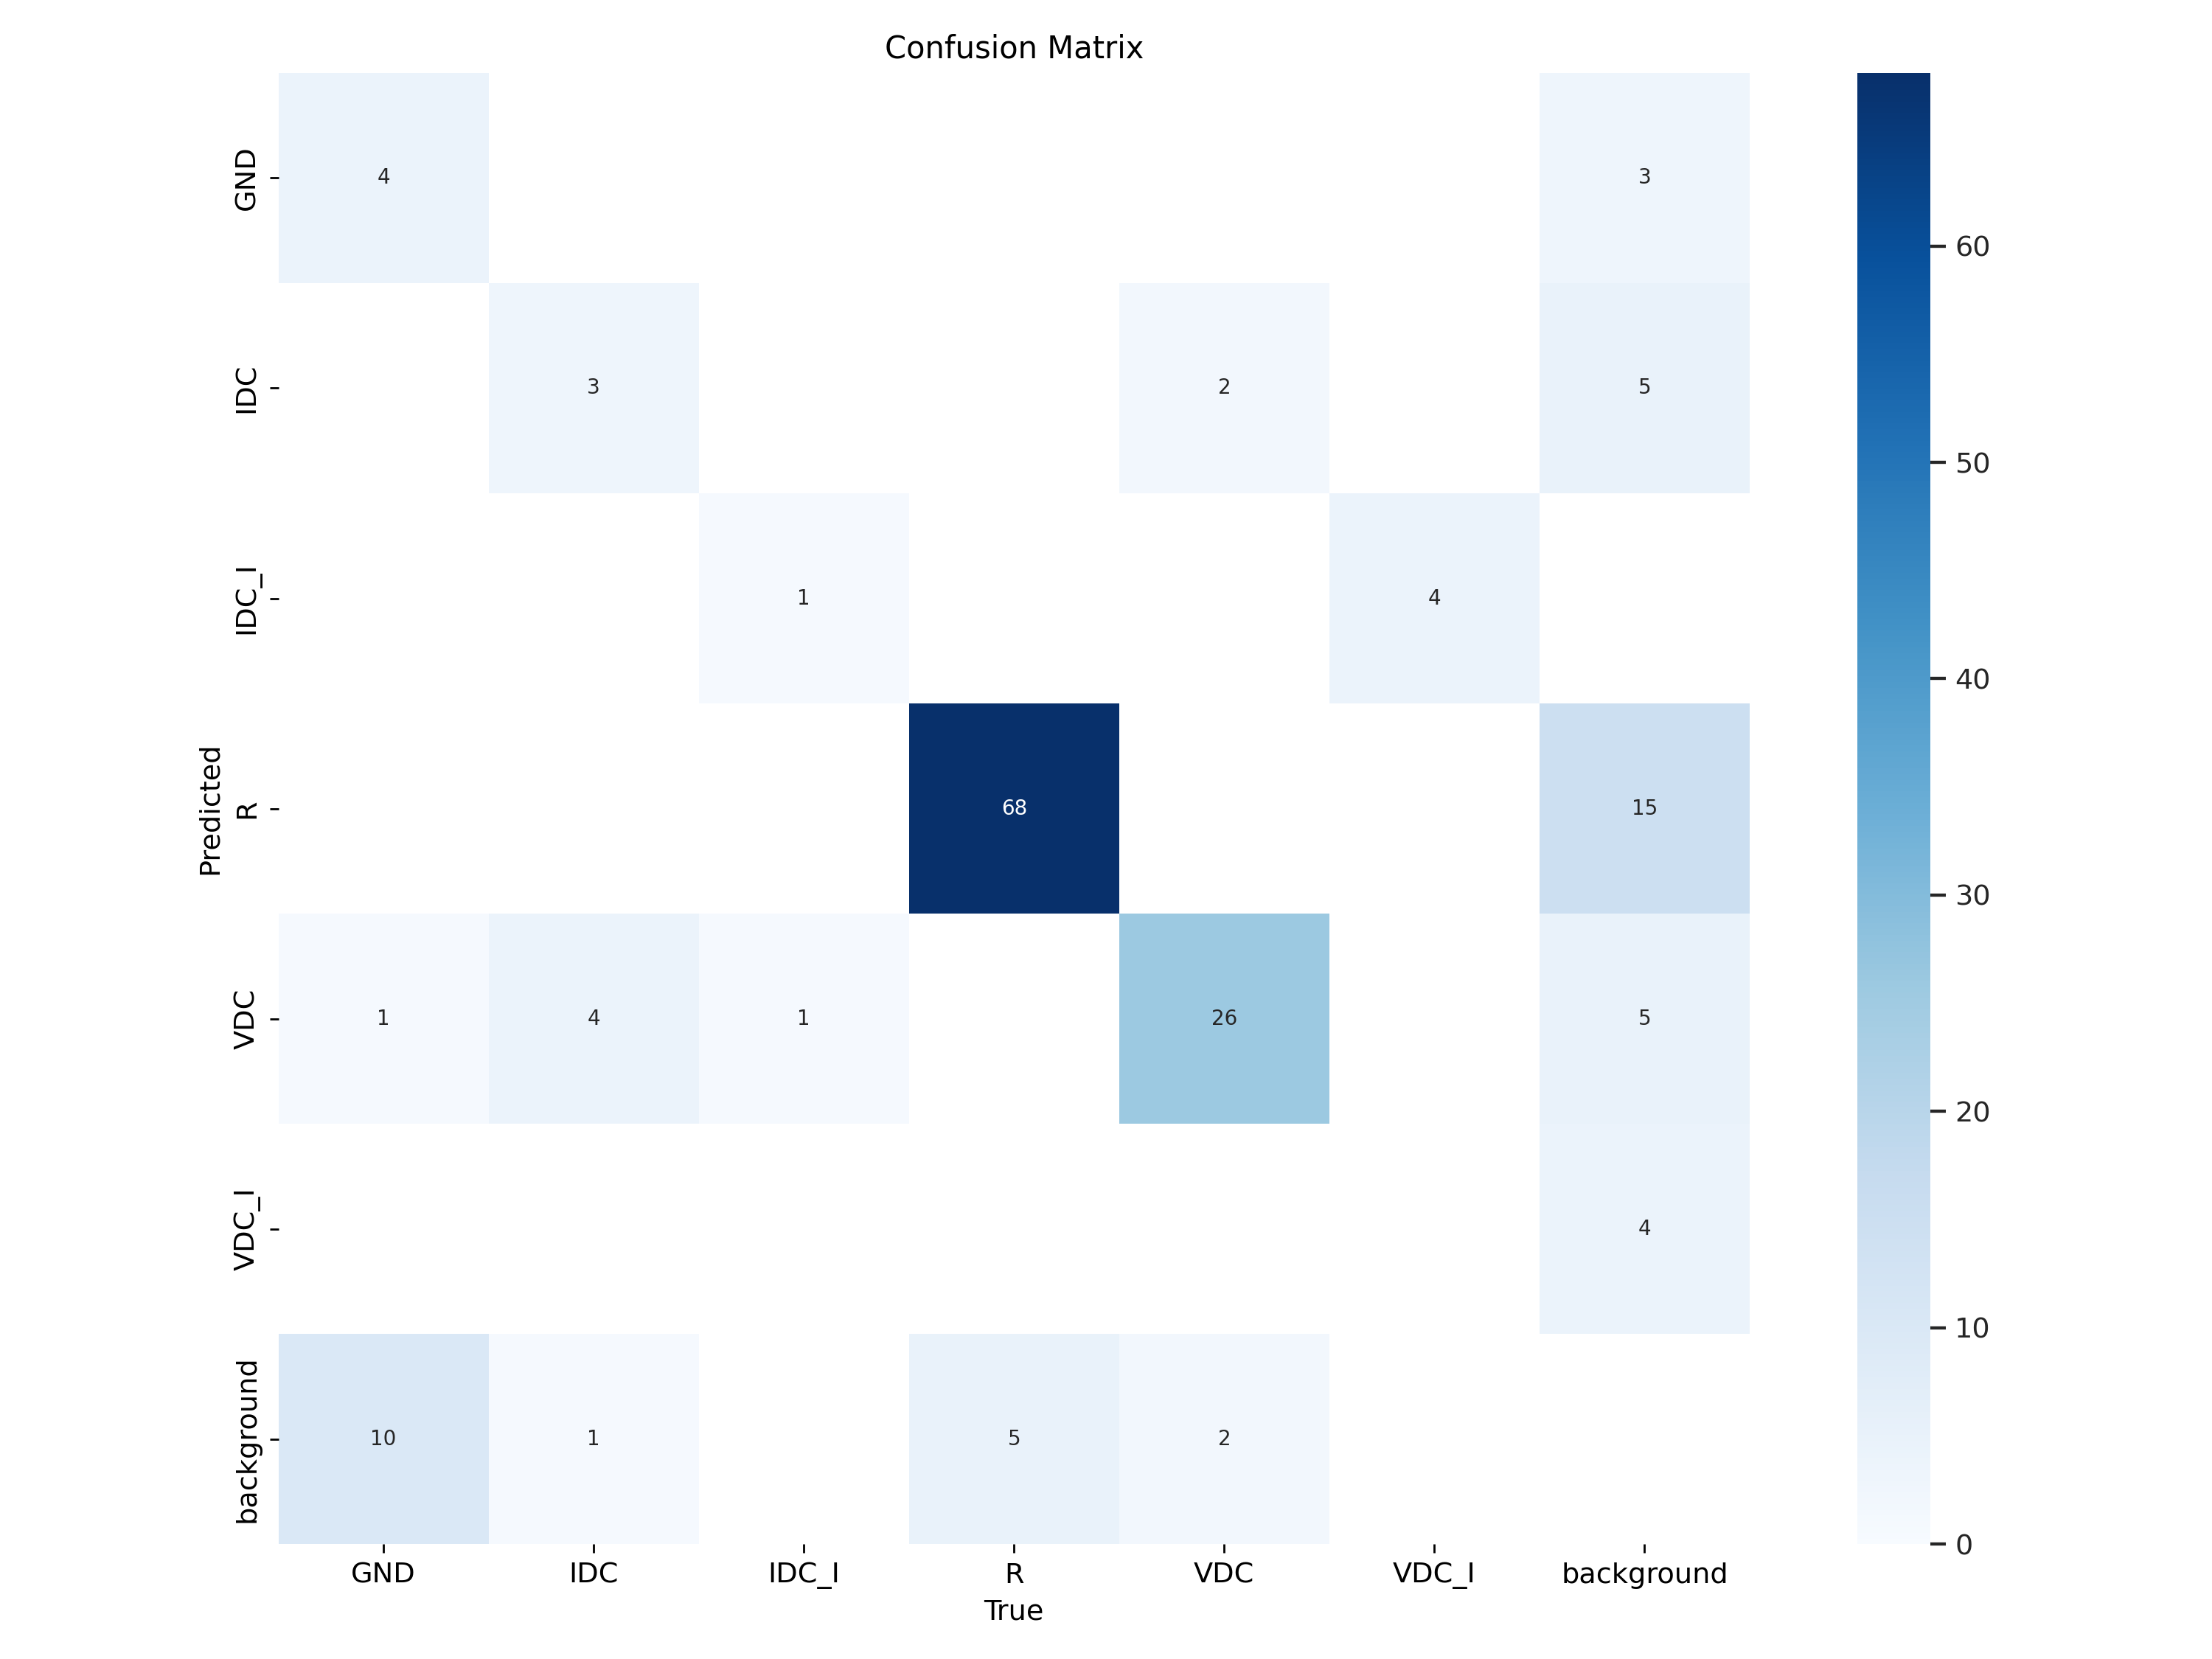

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

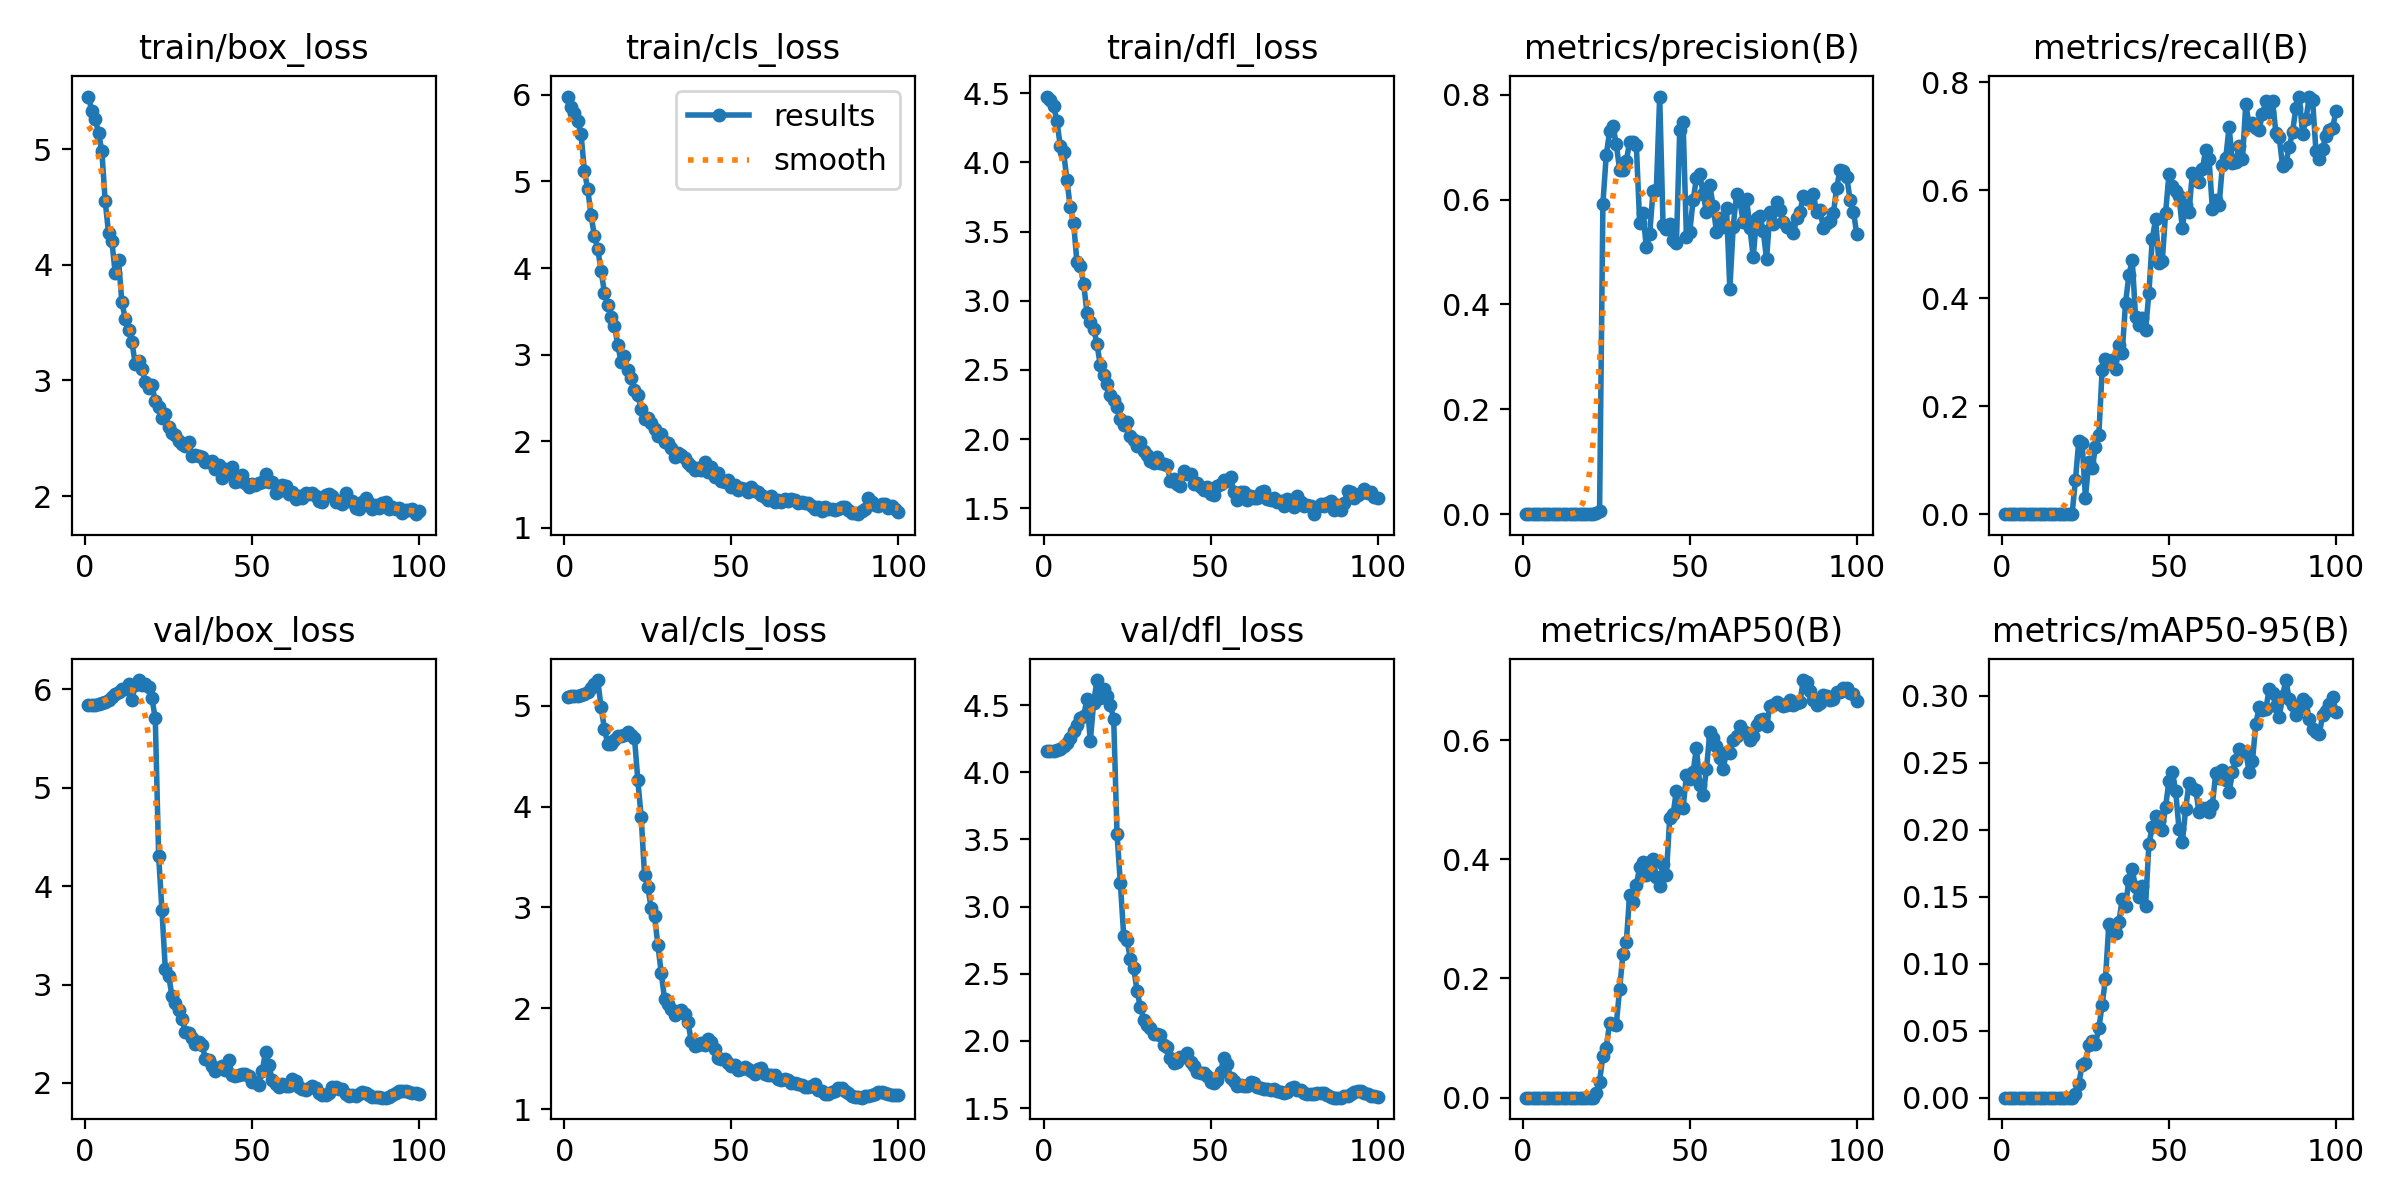

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['GND', 'IDC', 'IDC_I', 'R', 'VDC', 'VDC_I']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.36766015772865474
mAP 50 0.8446016030174445
mAP 75 0.20073643896421808


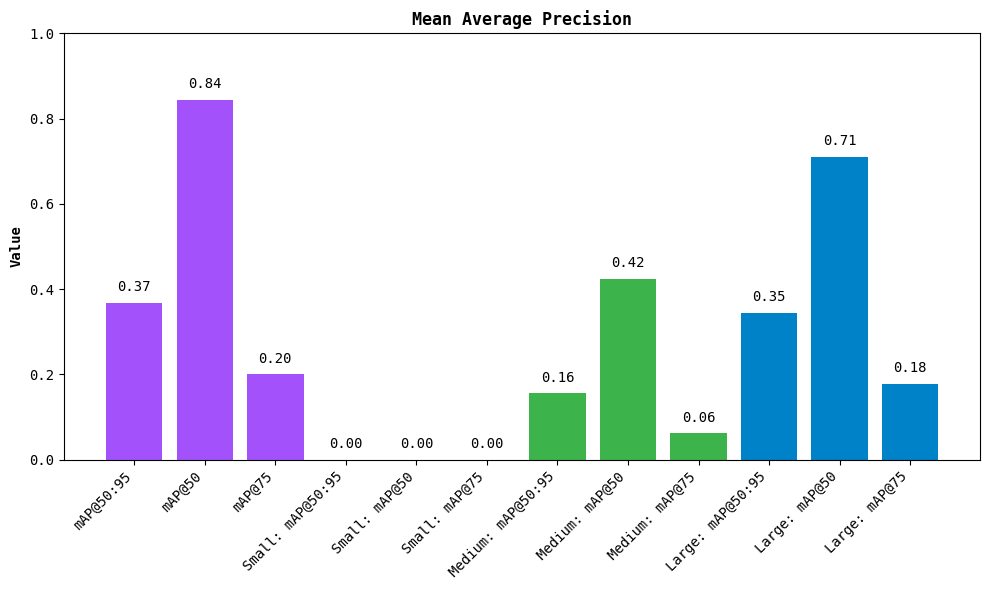

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

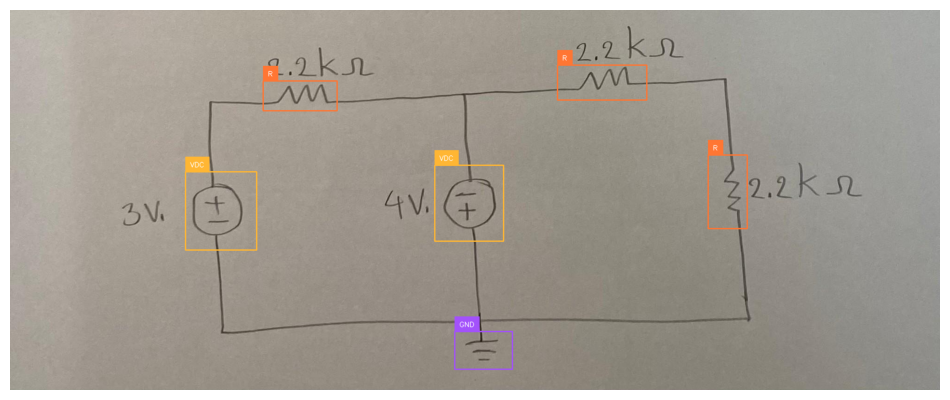

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)